<a href="https://colab.research.google.com/github/maxant38/TP-Arbre/blob/main/Tp_arbres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TP Arbres de décision - UP 2
Caille Maxence  
Lagrange Quentin  
Mucha Pasini Bruno  

## **Importation des librairies**

In [ ]:
import pandas as pd # to load and manipulate data and for One-Hot Encoding I
import numpy as np # to calculate the mean and standard deviation

import matplotlib.pyplot as plt # to draw graphs

from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree

from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation

from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to plot confusion matrix

from sklearn.metrics import plot_roc_curve,auc # to draw a confusion matrix



## **Chargement de données et pré traitement**

In [ ]:
seed = 26938 # on fixe une seed afin d'avoir les mêmes résultats si quelqu'un souhaite les réproduire.


In [ ]:
df = pd.read_csv('contact-lenses.csv', sep=';') # import du dataset
df.head()

,age,spectacle-prescrip,astigmatism,tear-prod-rate,contact-lenses
0,young,myope,no,reduced,none
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,none
3,young,myope,yes,normal,hard
4,young,hypermetrope,no,reduced,none


On vérifie le type de nos données et s'il y a des valeur manquantes ou abérrantes.


In [ ]:
df.dtypes

age                   object
spectacle-prescrip    object
astigmatism           object
tear-prod-rate        object
contact-lenses        object
dtype: object

In [ ]:
for c in df.columns:
  print(c, ':', df[c].unique())

age : ['young' 'pre-presbyopic' 'presbyopic']
spectacle-prescrip : ['myope' 'hypermetrope']
astigmatism : ['no' 'yes']
tear-prod-rate : ['reduced' 'normal']
contact-lenses : ['none' 'soft' 'hard']


Il n'y a aucune valeur manquante ou abérrante. Toutes nos variables sont des variables catégorielles. Il est donc nécessaire de les encoder pour pouvoir utiliser un arbre de décision.

In [ ]:
X = df.drop(['contact-lenses'], axis=1) # On enlève la valeur que l'on souhaite prédire
X = pd.get_dummies(X) # On encode nos variables catégorielles (encodage one-hot)
X.head() # on vérifie que notre encodage a bien marché

,age_pre-presbyopic,age_presbyopic,age_young,spectacle-prescrip_hypermetrope,spectacle-prescrip_myope,astigmatism_no,astigmatism_yes,tear-prod-rate_normal,tear-prod-rate_reduced
0,0,0,1,0,1,1,0,0,1
1,0,0,1,0,1,1,0,1,0
2,0,0,1,0,1,0,1,0,1
3,0,0,1,0,1,0,1,1,0
4,0,0,1,1,0,1,0,0,1


In [ ]:
# y = df['contact-lenses'].copy()
# y[y=='none'] = 0
# y[y=='soft'] = 1
# y[y=='hard'] = 2
# y = y.astype('int')

In [ ]:
y = df['contact-lenses'].copy() # on crée un dataframe pour la valeur que l'on souhaite prédire


# **Construction du premier arbre de classification**

Notre démarche pour ce TP est de construire un arbre "bêtement" et de l'améliorer au fur et à mesure. Dans un premier temps on a donc construit un arbre avec la libraire Scikit-Learn en utilisant leur modèle "DecisionTreeClassifier". On ne touche pas au paramètre par défault de la librairie.

In [ ]:
# single split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed) # On crée nos dataset train et test , avec un proportion 75-25

clf_dt = DecisionTreeClassifier(random_state=seed) # on définit notre modèle d'arbre. Le seuil minimum pour "split" est de 0 ,
# nous ne fixons aucun maximum de profondeur et la fonction utilisé pour calculer l'impureté est la fonction de Gini
clf_dt.fit(X_train, y_train) # on entraine notre modèle

DecisionTreeClassifier(random_state=26938)

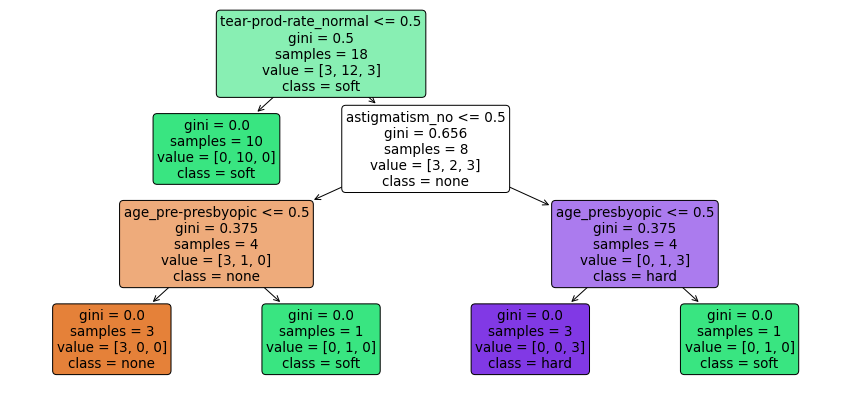

In [ ]:
plt.figure(figsize=(15, 7))
plot_tree(clf_dt, filled=True, rounded=True, class_names=['none', 'soft', 'hard'],feature_names=X.columns);

En regardant ce graphique de notre arbre, on peut émettre les hypothèses suivantes:
- notre dataset est très petit (>30 lignes) mais notre arbre a une profondeur de 4 
- on voit que deux des feuilles de l'arbre contiennent un seul élément
=> de ces deux points, on peut penser que notre arbre "overfit" nos données.

Nous allons ensuite regarder sa performance avec sa matrice de confusion:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


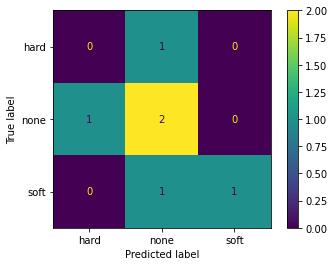

In [ ]:
plot_confusion_matrix(clf_dt, X_test, y_test)

On constate que l'on bien prédit la catégorie "soft". On a mal prédit la catégorie "hard". Et on a deux erreurs sur la catégories "none".

In [ ]:
test_score = [clf_dt.score(X_test, y_test)] # Renvoie la précision moyenne sur les données de test
print('test_score :', test_score)

test_score : [0.5]


On voit que le score (0.5) est un peu meilleur qu'une répartition aléatoire (1/3 = 0.333...) mais nous allons effectuer un élagage afin d'avoir une meilleure prediction. Car comme évoqué précédemment, notre arbre "overfit" les données d'entrainement.

# **Elagage de notre arbre**

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determiner valeurs pour alpha
ccp_alphas = path.ccp_alphas # extraction des différentes valeurs pour alpha
#ccp_alphas = ccp_alphas[:-1] # exclure la valeur maximale pour alpha afin de ne pas avoir un arbre avec seulement une feuille
clf_dts = [] # créer un tableau dans lequel nous placerons les arbres de décision

# créer maintenant un arbre de décision par valeur pour alpha et le stocker dans le tableau 
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf_dt. fit(X_train, y_train)
    clf_dts.append(clf_dt) 


In [ ]:
path

{'ccp_alphas': array([0.        , 0.08333333, 0.08333333, 0.125     , 0.20833333]),
 'impurities': array([0.        , 0.08333333, 0.16666667, 0.29166667, 0.5       ])}

In [ ]:
ccp_alphas

array([0.        , 0.08333333, 0.08333333, 0.125     , 0.20833333])

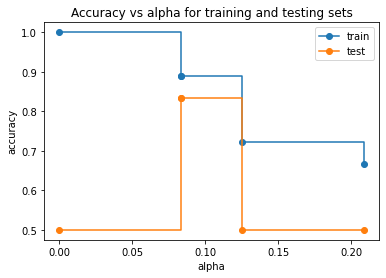

In [ ]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax. legend()

### Cross validation

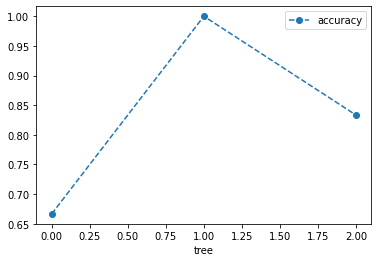

In [ ]:
clf_dt= DecisionTreeClassifier(random_state=seed, ccp_alpha=0.08333333) # on fixe l'hyperparamètre alpha déterminer précédemment


#3 fold cross validation 

scores = cross_val_score(clf_dt, X_train, y_train, cv=3)
df = pd.DataFrame(data={'tree': range(3), 'accuracy':scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')


# On constate que l'accuracy change selon le dataset. Cela veut dire que notre alpha est sensible au dataset.
On va donc utiliser la cross validation pour trouver le alpha optimal.


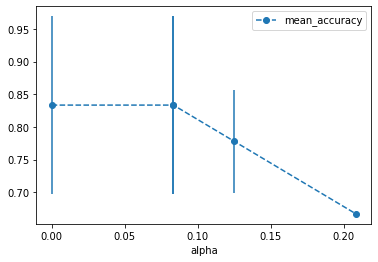

In [ ]:
## créer un tableau pour stocker les résultats de chaque fold pendant la validation croisée
alpha_loop_values = []

## Pour chaque valeur candidate pour alpha, nous effectuerons une validation croisée 3 fois.
## Ensuite, nous enregistrerons la moyenne et l'écart type des scores (la précision) pour chaque appel
## à cross_val_score dans alpha_loop_values.
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=3)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

## Maintenant nous pouvons dessiner un graphique des moyennes et des écarts types des scores
## pour chaque valeur candidate pour alpha
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',y='mean_accuracy',yerr='std',marker='o',linestyle='--')

In [ ]:
print(alpha_results)

      alpha  mean_accuracy       std
0  0.000000       0.833333  0.136083
1  0.083333       0.833333  0.136083
2  0.083333       0.833333  0.136083
3  0.125000       0.777778  0.078567
4  0.208333       0.666667  0.000000


On peut voir que le 3ème alpha sur le graphique est le meilleur selon la mean_accuracy. On constate néanmoins qu'il a l'écart-type le plus élevé

In [ ]:
ideal_ccp_alpha = alpha_results.iloc[2]['alpha']
ideal_ccp_alpha

0.08333333333333333

## Construction de l'arbre final, avec élagage

In [ ]:
clf_dt_pruned = DecisionTreeClassifier(ccp_alpha=ideal_ccp_alpha)# avec alpha ideal = 0.08333333333333333
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


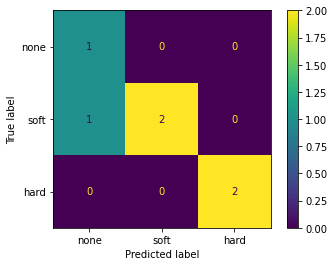

In [ ]:
plot_confusion_matrix(clf_dt_pruned, X_test, y_test,display_labels=['none', 'soft', 'hard'])


[Text(0.4, 0.8333333333333334, 'tear-prod-rate_normal <= 0.5\ngini = 0.5\nsamples = 18\nvalue = [3, 12, 3]\nclass = soft'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [0, 10, 0]\nclass = soft'),
 Text(0.6, 0.5, 'astigmatism_yes <= 0.5\ngini = 0.656\nsamples = 8\nvalue = [3, 2, 3]\nclass = none'),
 Text(0.4, 0.16666666666666666, 'gini = 0.375\nsamples = 4\nvalue = [0, 1, 3]\nclass = hard'),
 Text(0.8, 0.16666666666666666, 'gini = 0.375\nsamples = 4\nvalue = [3, 1, 0]\nclass = none')]

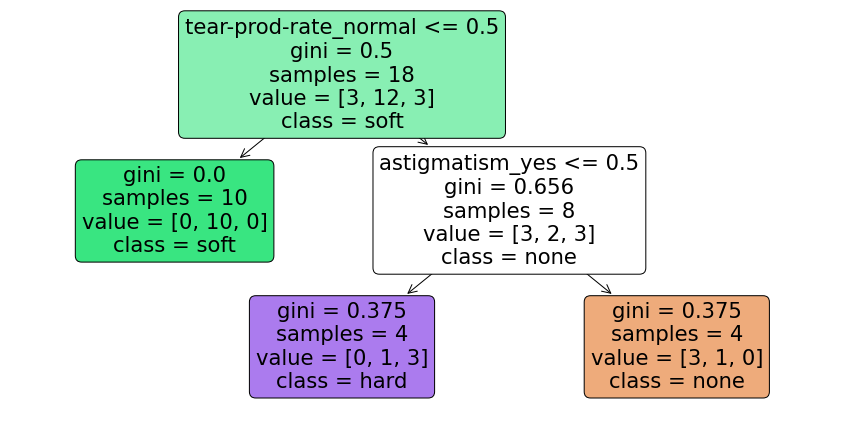

In [ ]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned, filled=True,rounded=True,class_names=['none', 'soft', 'hard'], feature_names=X.columns)

In [ ]:
test_score = [clf_dt_pruned.score(X_test, y_test)]
print('test_score :', test_score)

test_score : [0.8333333333333334]
